# PHASE 2 FINAL PROJECT

## INTRODUCTION
**Megamax Real Estate Agency** a well known Real Estate Agency in New York has decided to start a new division which connects home sellors to potential buyers for a small fee. It wants to find out how home rennovations may affect the **saleprices** of the homes of potential sellors. This is to advise potential sellors appropiately, to increase market appeal of their houses.

**Megamax Real Estate Agency** has decided to hire you as a Data Scientist to predict how rennovations may affect the price of a house. After analysis, you are to present your findings and insights to the head of the new division, who will use both to see how rennovations will affect the saleprice of the home of a potential sellor.

## OBJECTIVES
The objectives of the project are:
- To determine how rennovations affect the saleprice of the home of a potential sellor.
- To present findings and model to head of division so that the head may use the insights generated to advise potential sellors(clients).

## BUSINESS UNDERSTANDING
#### PROBLEM STATEMENT
To determine the effect of home rennovations on the saleprice of a home. This is to help Megamax Real Estate Agency in making informed decisions to potential sellors of homes who are their clients.

#### MEASUREMENT OF SUCCESS
The goal is to determine the effect of home rennovations on the saleprice of homes. The measure of success will therefore be after analysis has been done and insights generated,findings should be presented to the head of the new divisions who will use both to advise new sellors appropiately.

## DATA UNDERSTANDING
For the problem at hand the data used to see the effect of rennovations on the price of houses was the King County House Sales dataset. This dataset was sourced from Kaggle and is relevant to the problem at hand as it contains data about relevant features of houses together with the price of such homes. These features are in the form of columns in a dataframe and they include:

- **Price** : This is the target(dependent) variable and is what we want to see the effect of rennovations on.

- **Bedrooms**: This is the number of bedrooms a house has and is one of the rennovations that may be performed to see the effect of SalePrice such that one may add or remove bedrooms to see the effect on SalePrice.

- **Floors**: This is the number of floors a house has and is relevant to the problem as a potential sellor may want to know the effect of adding or removing floors may have on the selling price of his/her home.

- **Condition**: This is the overall condition which has unique values as follows ['Average', 'Very Good', 'Good', 'Poor', 'Fair']. It is relevant to our problem as the client may want to know whether rennovation of the house to make it look new will increase or decrease the selling price of the house.

- **sqft_above**: This is the overall square footage of the house minus the basement. It is relevant as this factor shows whether the size of the house minus the basement determines its selling price. A client with enough land may even decide to increase its size to see if it will increase its asking price.

- **waterfront**: This is the prescence of a waterfront in front of the house. A client may want to know whether adding a waterfront will decrease or increase the selling price of his/her home.

- **grade**: This is the type and quality of the material used in construction of houses. It also includes the finishing and the design quality of the house and the interiors. It is relevant to the problem as a client may want to know whether using high quality materials in the rennovation of his/ her house will lead to increase or decrease in the price of the house.

## DATA PREPARATION

Before data is used for analysis one must ensure the data is clean. This is by:

- **Removing outliers**: Identification and removal of data points that deviate significantly from the overall distribution, as they can adversely impact analysis results.

- **Handling missing values**: Thoroughly checking for missing values and employing appropriate strategies to handle them, such as imputation techniques or assessing the suitability of the missing data for analysis.

- **Identifying and resolving duplicates**: Identifying and removing duplicate records to ensure data integrity and avoid bias in analysis outcomes.

- **Assessing columns with excessive missing values**: Evaluating columns with a substantial number of missing values and determining their relevance to the analysis. Dropping columns that are not essential or exploring alternative strategies for handling missing data.


- **Correcting data types**: Verifying and correcting the data types of variables to align them with their intended representation (e.g., converting numerical data from strings to numeric types).



**This was done by first loading important libraries that will be used for data preparation and for this project.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

**The data is then loaded to see how the dataset looks like**

In [2]:
house_data = pd.read_csv('data/kc_house_data.csv')
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


**Checking the general info of the dataframe such as the datatypes of each column and whether or not each column has missing values.**

In [3]:
# Looking at general info of the dataframe missing values and the dtypes of each column in the dataframe
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Several columns have missing values so now the task is to check the percentage of missing values for each column in the dataframe so as to know what to handle these missing values**.

In [4]:
# Function for checking percentage of missing values in every column in the dataframe and putting values in a dictionary then a dataframe
# Also creates a new column for the datatype of the columns.
def missing_percentage(df):

    # Dictionary for putting percentage of missing values
    missing_values_percentage = {}
    
    # Loop for calculating percentage of missing values and putting values in dictionary
    for column in df.columns:
        missing_values_percentage[column] = df[column].isnull().sum() / len(df[column]) * 100

    # Creating dataframe of the dictionary
    missing_df = pd.Series(missing_values_percentage)
    missing_df = pd.DataFrame(missing_df, columns=['Percentage Missing'])


    # Creating a new column for the dtype of the column with missing values.
    missing_df['dtype'] = [df[column].dtypes for column in missing_df.index]

    return missing_df





**Creating a copy of the house data dataframe to see if the function to check the percentage of missing values in the dataframe works before proceeding to apply it to the actual dataset**

In [5]:
# Copy of data to test our new function.
X_test = house_data.copy()

# Testing
missing_percentage(X_test)

,Percentage Missing,dtype
id,0.000000,int64
date,0.000000,object
price,0.000000,float64
bedrooms,0.000000,int64
bathrooms,0.000000,float64
sqft_living,0.000000,int64
sqft_lot,0.000000,int64
floors,0.000000,float64
waterfront,11.001528,object
view,0.291707,object


**Now applying the same function to the actual dataset to see the percentage of missing values for each column in the dataframe**.

In [6]:
missing_percentage(house_data)

,Percentage Missing,dtype
id,0.000000,int64
date,0.000000,object
price,0.000000,float64
bedrooms,0.000000,int64
bathrooms,0.000000,float64
sqft_living,0.000000,int64
sqft_lot,0.000000,int64
floors,0.000000,float64
waterfront,11.001528,object
view,0.291707,object


 It appears the **view**, **waterfront** and **yr_renovated** columns have missing data we shall deal with each individually

In [7]:
# For the view column only 0.291707% of its data is missing so we can just drop the rows with missing values.
house_data.dropna(subset='view', inplace=True)

# Checking to see if it worked
house_data.isnull().sum()


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2370
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3830
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**The view column no longer has missing values.**

For the waterfront column we want to see if the presence of a waterfront does indeed affect the price of the house so will create two copies of the dataframe one which we fill missing values with yes and the other we fill with no to see what happens starting with no.

In [8]:
# We begin with creating a copy of the dataframe which we fill missing values with no.
no_df = house_data.copy()

# Filling missing values with the mode which was no.
no_df['waterfront'].fillna(no_df['waterfront'].mode()[0], inplace=True)

# Checking to see if it worked
no_df.isnull().sum()  # It worked

# Converting waterfront to numerical data
no_df['waterfront'] = pd.factorize(no_df['waterfront'])[0]

# Checking the correlation with a majority of no values.
np.corrcoef(no_df['waterfront'], no_df['price'])[0][1]


0.2592199841632747

With the majority of values being no the correlation between the column waterfront and the column price is **0.0754613848461221** now lets see if we fill the missing values with yes.

In [9]:
yes_df = house_data.copy()

# Filling missing values with the mode which was no.
yes_df['waterfront'].fillna('yes', inplace=True)

# Checking to see if it worked
yes_df.isnull().sum()  # It worked

# Converting waterfront to numerical data
yes_df['waterfront'] = pd.factorize(yes_df['waterfront'])[0]

# Checking the correlation with a majority of no values.
np.corrcoef(yes_df['waterfront'], yes_df['price'])[0][1]

0.0754613848461221

**Since either way there seems to be no change in the correlation we shall proceed to fill missing values of the waterfront with the mode of the column.**

In [10]:
house_data['waterfront'].fillna(house_data['waterfront'].mode()[0], inplace=True)

# Checking to see if it worked
house_data.isnull().sum()  # It worked now only the yr_renovated column.

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3830
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Now we deal with the yr_renovated column which has **3830** missing values. Which is **17.789508%** of its data missing.

First step so as to know how to deal with the missing valuesis to draw a scatter plot of Price against yr_renovated. This will help us see if there's a correlation between year renovated and the price so that we can see the effect of missing values on that correlation.

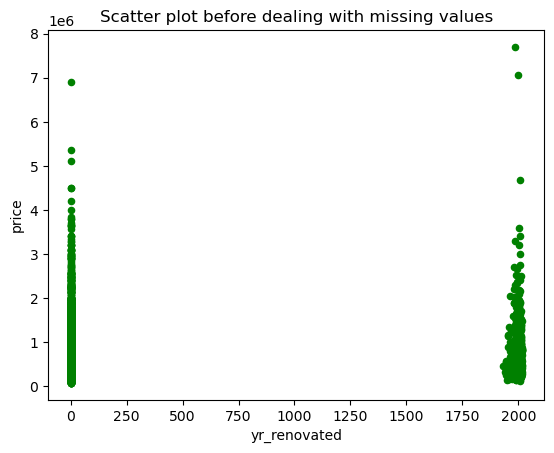

In [11]:
house_data.plot.scatter(x='yr_renovated', y='price', c='green');
plt.title('Scatter plot before dealing with missing values');

**There seems to be no correlation between the yr_renovated and the price of the house let us see what happens if we fill it with the mean.**

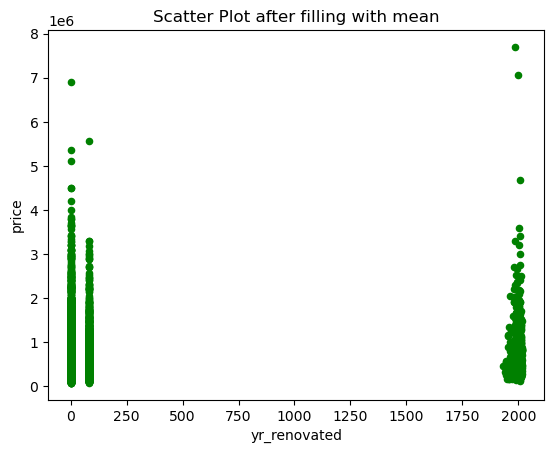

In [12]:
# Lets create a copy before doing it on the actual dataframe.
test_data = house_data.copy()

# We now filling missing values of this copy of the dataframe with the mean to see what happens to the correlation between the two.
test_data['yr_renovated'].fillna(test_data['yr_renovated'].mean(), inplace=True)

# Seeing if the original dataframe was affected.
house_data.isnull().sum()  # No effect.

# Plotting scatter plot with test data.
test_data.plot.scatter(x='yr_renovated', y='price', c='green')
plt.title('Scatter Plot after filling with mean');


**Filling with the missing values with mean seems to have no effect on the correlation between the yr_renovated column and the price column let us see what happens if we fill with the mode.**

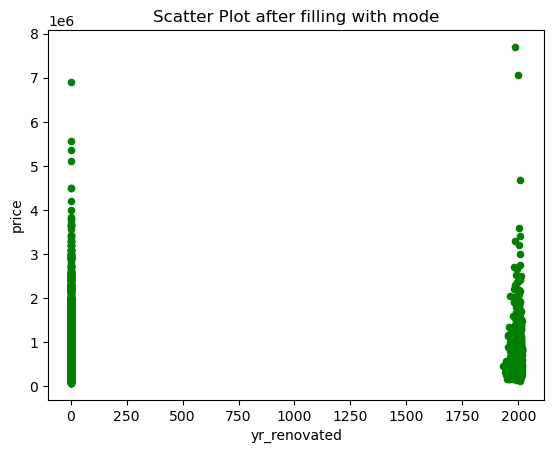

In [13]:
# Creating copy
new_test_data = house_data.copy()

# Filling copy with mode of column
new_test_data['yr_renovated'].fillna(new_test_data['yr_renovated'].mode()[0], inplace=True)

# Checking to see if missing values of copy have been filled
new_test_data.isnull().sum()

# Plotting scatter plot
new_test_data.plot.scatter(x='yr_renovated', y='price', c='green')
plt.title('Scatter Plot after filling with mode');

**The reason why we chose to see the effects of filling the missing values with mean or mode is we wanted to see if there's a correlation between the independent variable and the dependent variable and if filling missing values with mean or mode would have an effect on this correlation. There however seems to be no correlation between the two, so even if we fill with the mean, which we'll do it should have no effect on the relationship between the independent and dependent variable.**

In [14]:
# Filling missing values of 'yr_renovated' column with the mean of the values.
house_data['yr_renovated'].fillna(house_data['yr_renovated'].mean(), inplace=True)

# Seeing if it worked
house_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### The missing values have been dealt with we now want to check for wrong datatypes as part of the data preparation process.

#### This we will do by creating a function that checks for wrong datatypes in a dataframe.

In [15]:
# Function for checking for wrong datatypes in each column in the dataframe.

def wrong_data(df):
    # Dictionary for mapping
    value_types = {
        'int64': int,
        'object': str,
        'float64': float
    }
    # Dictionary for mapping columns with wrong datatypes
    wrong_data_types = {}

    # Loop which checks for every column in the dataframe if it has wrong datatypes.
    for column in df.columns:
        wrong_data_types[column] = [x for x in df[column] if type(x) != value_types[str(df[column].dtypes)]]

    # Final results
    return wrong_data_types



#### After creating our function we test it on our dataframe **house_data**

In [16]:
# Testing our function on a copy of the data
wrong_data(house_data)



{'id': [],
 'date': [],
 'price': [],
 'bedrooms': [],
 'bathrooms': [],
 'sqft_living': [],
 'sqft_lot': [],
 'floors': [],
 'waterfront': [],
 'view': [],
 'condition': [],
 'grade': [],
 'sqft_above': [],
 'sqft_basement': [],
 'yr_built': [],
 'yr_renovated': [],
 'zipcode': [],
 'lat': [],
 'long': [],
 'sqft_living15': [],
 'sqft_lot15': []}

### There appears to be no wrong datatypes in our house dataset the next is to deal with outliers in the data we shall do this by creating a function to do this.

First we want to see how the dependent variable looks before outliers are removed.

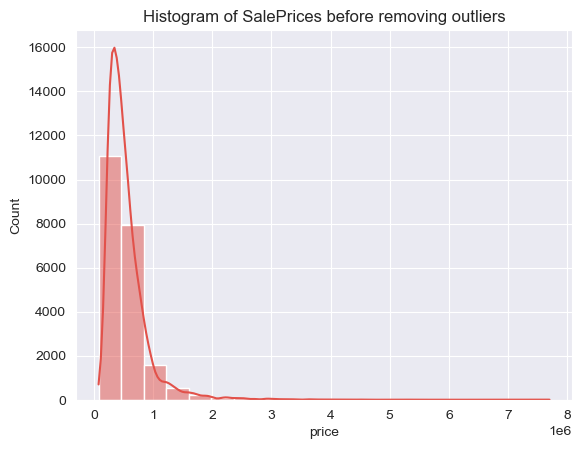

In [35]:
# Histogram of price before removing outliers
# setting a style for plots
sns.set_palette("Spectral")
sns.set_style("darkgrid")

# Plotting
sns.histplot(house_data['price'], kde=True, bins=20)
plt.title('Histogram of SalePrices before removing outliers');

**Before outliers are removed the graph appears to be left skewed with majority of the data on the left side.**

Since outliers can only be checked and removed on numeric variables we will seperate the numeric and categorical variables to deal with the numeric variables seperately.

In [18]:
# Creating a copy of the dataframe to remove outliers to see if it works before applying to our real data.
X_test = house_data.copy()

# Isolating numeric variables
numeric_variables = X_test.select_dtypes(include=np.number).columns.to_list()

numeric_variables

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [19]:
# Function for checking outliers in a dataframe removing them and creating a new dataframe without outliers
def outliers(df):

    # Dictionary for placing no. of outliers and the column name.
    outliers_dict = {}
    standardized_dict = {}

    # For loop for checking outliers in every column in the dataframe.
    for column in df.columns:
        # Lower quantile
        Q1 = df[column].quantile(0.25)

        # Upper Quantile
        Q3 = df[column].quantile(0.75)

        # Finding IQR
        IQR = Q3 - Q1

        # Defining lower and upper bound
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Finding outliers
        outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_dict[column] = 'The number of outliers is', len(outliers)

        # Data without outliers
        standardized_numvotes = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        # Putting standardized values in a dict
        standardized_dict[column] = standardized_numvotes

    
    standardized_df = pd.DataFrame(standardized_dict)  

    # Results
    return standardized_df

After creating our function for removing outliers we can now test it on a copy of the dataframe **X_test** to see if it works

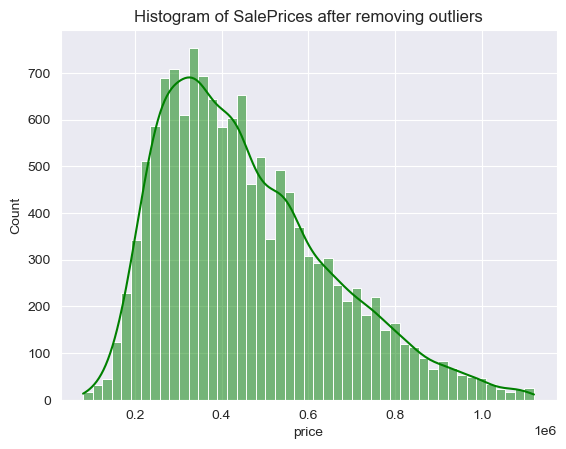

In [64]:
new_df = outliers(X_test[numeric_variables])

# Since all values which are not within the range will now be Nan values 
new_df.dropna(inplace=True)

# Histogram of price after removing outliers.
sns.histplot(new_df['price'], kde=True, color='green', bins='auto')
plt.title('Histogram of SalePrices after removing outliers');

**After removing outliers it appears the data for the SalePrice appears to be almost following a bell curve**.

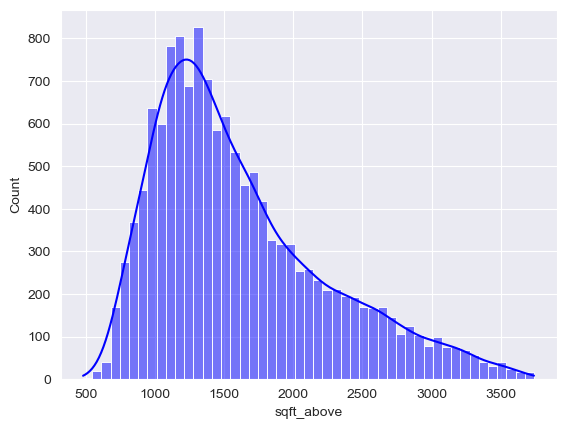

In [65]:
sns.histplot(new_df['sqft_above'], kde=True, color='blue');

### Now the final task in data cleaning is to check for duplicates in our dataframe.

In [66]:
# Checking for duplicates
house_data[house_data.duplicated()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### There are no duplicates in the dataset.

**Now that there are no longer missing values, outliers, wrong datatypes and duplicates in the dataset we can move on to Exploratory Data Analysis.**

## EXPLORATORY DATA ANALYSIS

In [67]:
# Checking if the new_df has null values
new_df.isnull().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
sqft_above       0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [70]:
# Finding correlation of each independent variable to the target variable and putting values in a dictionary.
corr_dict = {}

for column in new_df.columns:
    corr_dict[column] = np.corrcoef(new_df[column], new_df['price'])[0][1]

c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [88]:
len(new_df.columns)

15